In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns


def generate_synthetic_data_from_mean_gini(target_mean, target_gini, size=1_000_000, seed=4):
    """
    Generate synthetic data from a lognormal distribution that approximates a given mean and Gini coefficient.

    Parameters:
        target_mean (float): Desired mean of the synthetic distribution.
        target_gini (float): Desired Gini coefficient of the distribution.
        size (int): Number of samples to generate (default: 1000).
        seed (int or None): Random seed for reproducibility (default: None).

    Returns:
        np.ndarray: Synthetic data array.
    """

    # Set random seed if provided
    if seed is not None:
        np.random.seed(seed)

    # Gini of a lognormal: G = 2 * Φ(σ/√2) - 1
    def lognormal_gini(sigma: float) -> float:
        return 2 * norm.cdf(sigma / np.sqrt(2)) - 1

    # Objective function to minimize: match mean and Gini
    def objective(params: np.ndarray) -> float:
        mu, sigma = params
        mean = np.exp(mu + sigma**2 / 2)
        gini = lognormal_gini(sigma)
        # Weighted sum to prioritize Gini matching (since mean is easier to match)
        return (mean - target_mean) ** 2 + 100 * (gini - target_gini) ** 2

    def gini(array: np.ndarray) -> float:
        # Use the definition for population Gini
        array = np.sort(array)
        n = array.size
        index = np.arange(1, n + 1)
        return (2 * np.sum(index * array)) / (n * np.sum(array)) - (n + 1) / n

    # Initial guess
    initial_guess = [np.log(target_mean), 1.0]

    # Use a deterministic optimizer and tighter tolerance for reproducibility
    result = minimize(
        objective,
        initial_guess,
        bounds=[(None, None), (1e-6, None)],
        method="L-BFGS-B",
        options={"ftol": 1e-12, "gtol": 1e-8, "maxiter": 1e12}
    )
    mu_opt, sigma_opt = result.x

    # Use a fixed random seed for reproducibility
    rng = np.random.default_rng(seed)
    synthetic_data = rng.lognormal(mean=mu_opt, sigma=sigma_opt, size=size)

    # Calculate the mean and Gini of the generated data
    generated_mean = np.mean(synthetic_data)
    generated_gini = gini(synthetic_data)

    return synthetic_data, generated_mean, generated_gini, target_mean, target_gini

synthetic_data_uk_gapminder, generated_mean_uk_gapminder, generated_gini_uk_gapminder, target_mean_uk_gapminder, target_gini_uk_gapminder = generate_synthetic_data_from_mean_gini(target_mean=3784.226727, target_gini=0.5845)
synthetic_data_uk_moatsos, generated_mean_uk_moatsos, generated_gini_uk_moatsos, target_mean_uk_moatsos, target_gini_uk_moatsos = generate_synthetic_data_from_mean_gini(target_mean=1250.072, target_gini=0.5927)

synthetic_data_sweden_gapminder, generated_mean_sweden_gapminder, generated_gini_sweden_gapminder, target_mean_sweden_gapminder, target_gini_sweden_gapminder = generate_synthetic_data_from_mean_gini(target_mean=1619.685668, target_gini=0.4956)
synthetic_data_sweden_moatsos, generated_mean_sweden_moatsos, generated_gini_sweden_moatsos, target_mean_sweden_moatsos, target_gini_sweden_moatsos = generate_synthetic_data_from_mean_gini(target_mean=445.4332, target_gini=0.5544166)

In [2]:
def plot_synthetic_data(data, mean, gini, original_mean, original_gini, country, source, ipl):

    kde_plot = sns.kdeplot(
                data=data,
                log_scale=True,
                fill=True,
            )

    # Customize x-axis ticks to show 1, 2, 5, 10, 20, 50, 100, etc.
    # kde_plot.set(xscale="log")
    kde_plot.set_xticks([
                100,
                200,
                500,
                1000,
                2000,
                5000,
                10000,
                20000,
                50000,
                100000,
                200000,
            ])
    kde_plot.get_xaxis().set_major_formatter(plt.ScalarFormatter())

    # Make the plot wider
    fig = kde_plot.get_figure()
    fig.set_size_inches(10, 6)


    # Add a title mentioning mean, gini, country, and source
    kde_plot.set_title(
        f"Mean: {mean:.2f} (original {original_mean:.2f}), Gini: {gini:.2f} (original {original_gini:.2f}), Country: {country}, Source: {source}",
        fontsize=16,
    )

    # Plot dotted vertical line for ipl
    kde_plot.axvline(x=ipl*365, color='gray', linestyle='--', label=f'IPL: {ipl:.2f} a day')

    # Estimate the percentage below this line
    percentage_below_ipl = np.sum(data < ipl*365) / len(data) * 100

    kde_plot.text(
        ipl*365 * 0.90,
        kde_plot.get_ylim()[1] * 0.05,
        f"{percentage_below_ipl:.1f}% living below {ipl:.2f} a day",
        color='gray',
        fontsize=12,
        ha='center',
        rotation=90,
    )


    plt.show()

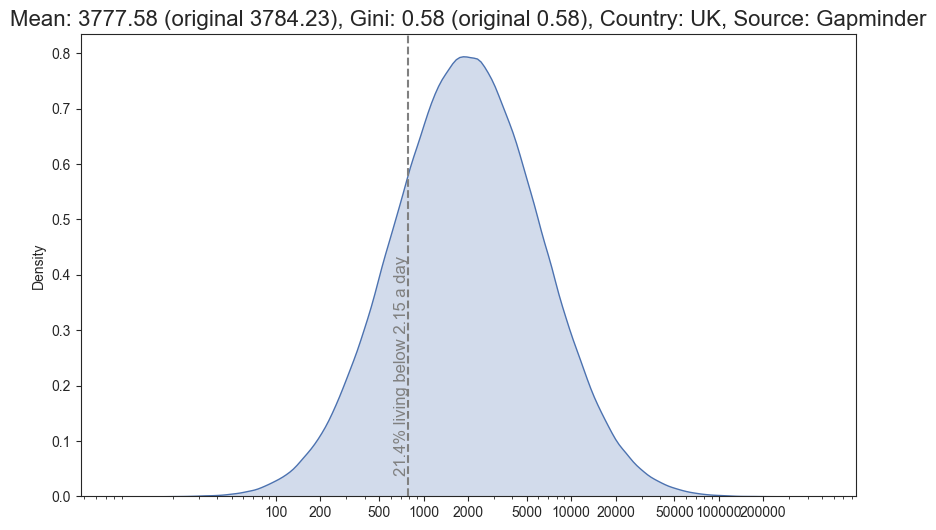

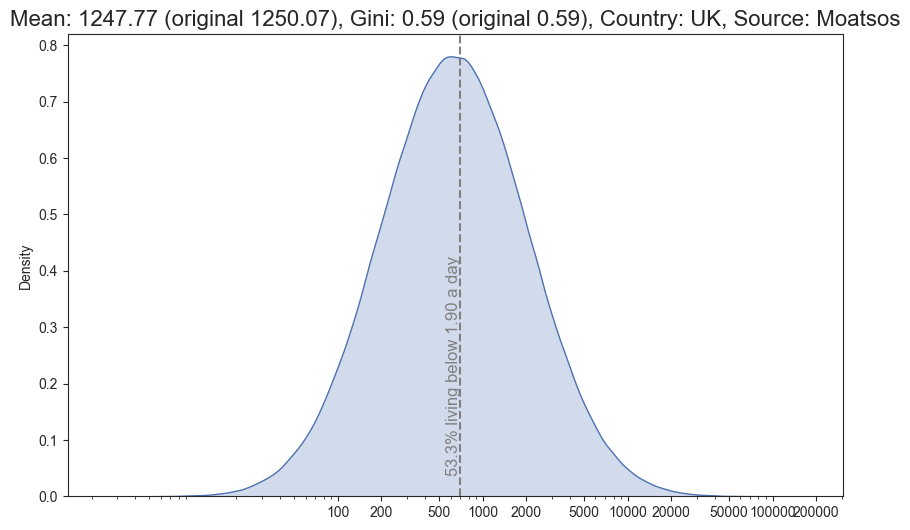

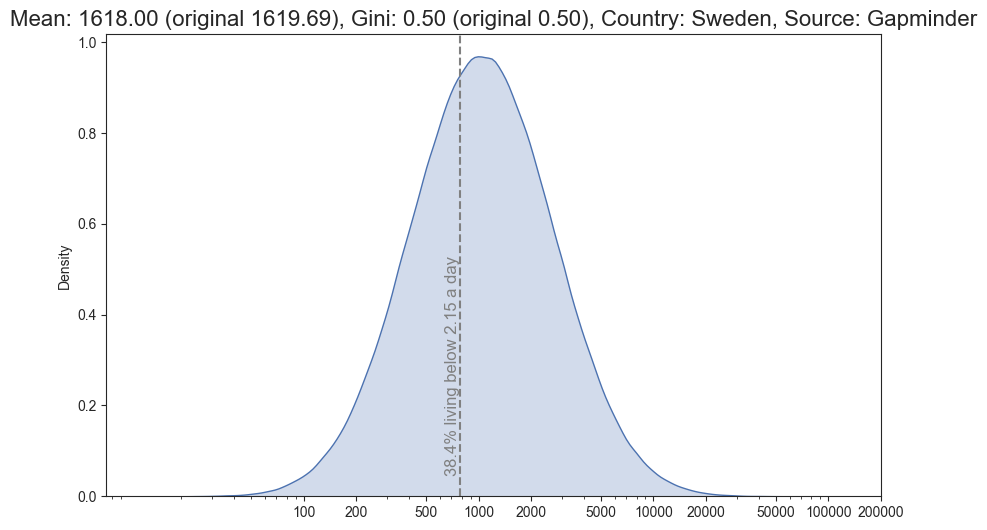

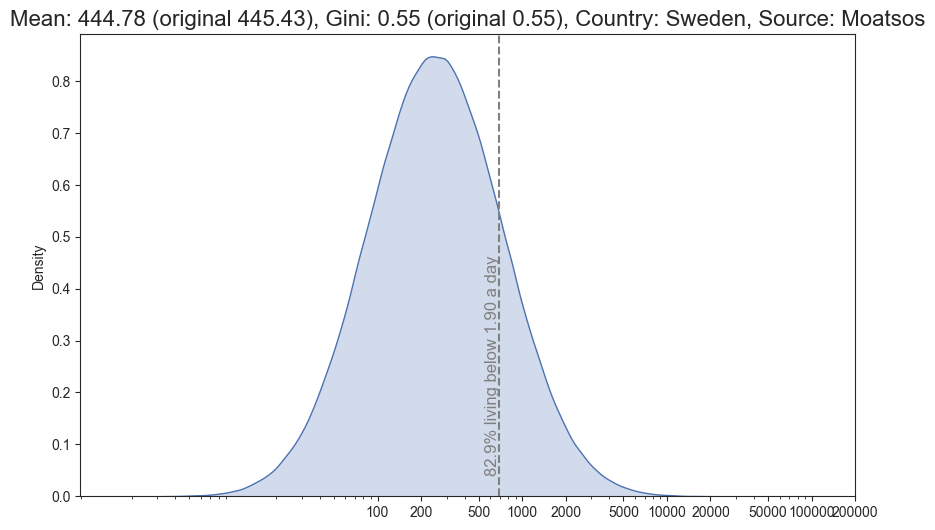

In [3]:
# Set seaborn style and color palette
sns.set_style("ticks")
sns.set_palette("deep")

plot_synthetic_data(
    data=synthetic_data_uk_gapminder,
    mean=generated_mean_uk_gapminder,
    gini=generated_gini_uk_gapminder,
    original_mean=target_mean_uk_gapminder,
    original_gini=target_gini_uk_gapminder,
    country="UK",
    source="Gapminder",
    ipl=2.15,
)
plot_synthetic_data(
    data=synthetic_data_uk_moatsos,
    mean=generated_mean_uk_moatsos,
    gini=generated_gini_uk_moatsos,
    original_mean=target_mean_uk_moatsos,
    original_gini=target_gini_uk_moatsos,
    country="UK",
    source="Moatsos",
    ipl=1.90,
)
plot_synthetic_data(
    data=synthetic_data_sweden_gapminder,
    mean=generated_mean_sweden_gapminder,
    gini=generated_gini_sweden_gapminder,
    original_mean=target_mean_sweden_gapminder,
    original_gini=target_gini_sweden_gapminder,
    country="Sweden",
    source="Gapminder",
    ipl=2.15,
)
plot_synthetic_data(
    data=synthetic_data_sweden_moatsos,
    mean=generated_mean_sweden_moatsos,
    gini=generated_gini_sweden_moatsos,
    original_mean=target_mean_sweden_moatsos,
    original_gini=target_gini_sweden_moatsos,
    country="Sweden",
    source="Moatsos",
    ipl=1.90,
)